# Introduction to differentiable modelling
## Demystifying the adjoint method
_Ivan Utkin_

VAW, 13 January 2023

## Motivation

Let's broadly classify models as being either _physics-bases_ or _data-driven_.

Physics-based models| Data-driven models
:-------------------|:-----------------
✅ Allow us to explain the observations                   | ✅ Can capture complex nonlinear effects
✅ Respect laws of physics (mass/momentum/energy balance) | ✅ Are computationally efficient
❌ Incorporating all relevant effects is often impossible | ❌ Need vast amounts of data for training
❌ Resolving scales is computationally challenging        | ❌ Data is sparse → training should be constrained

Modern approaches to modelling include both data-driven and physics-based components.

These components need to be calibrated to match observations and experimental data.

__The purpose of this talk is to explain in simple terms the state-of-the-art in model calibration, applicable to both physics-based and data-driven approaches, and combinations thereof.__

<center><img src="figures/PIANN.png" width="40%"/></center>

<font size="4">Riel, B., Minchew, B., and Bischoff, T. "Data‐Driven Inference of the Mechanics of Slip Along Glacier Beds Using Physics‐Informed Neural Networks: Case Study on Rutford Ice Stream, Antarctica." _Journal of Advances in Modeling Earth Systems_ (2021).</font>

## What is a model?

A mapping between inputs $\boldsymbol{X}$ and outputs $\boldsymbol{Y}$ parametrised by $\boldsymbol{\lambda}$ (control):

$$
    \boldsymbol{Y} = U(\boldsymbol{X},\boldsymbol{\lambda})
$$

Examples:

- Linear model: $U(\boldsymbol{X},\boldsymbol{\lambda}) = \boldsymbol{X}\boldsymbol{\lambda} + \boldsymbol{\varepsilon}$;
- PDE-based model: $\mathcal{L}(U(\boldsymbol{X},\boldsymbol{\lambda})) = 0$, $\mathcal{L}$ — differential operator;
- ML-based model: $U(\boldsymbol{X},\boldsymbol{\lambda})$ is the output of a neural network/decision tree/etc.

## How to calibrate a model?

The goal is to find $\boldsymbol{\lambda}$ that minimises the deviation of the model from available data $\boldsymbol{Y}_\text{obs}$.

We describe this deviation by introducing the objective function $J(\boldsymbol{Y},\boldsymbol{Y}^\text{obs})$.

Important example is the root-mean-square-deviation (RMSD):

$$
    J(\boldsymbol{Y},\boldsymbol{Y}^\text{obs}) = \sqrt{\frac{1}{N}\sum_{i=1}^{N}\left(Y_i - Y^\text{obs}_i\right)^2}
$$

> 📖 __objective function__ == __loss function__ == __cost function__
>
> 📖 __model calibration__ == __training__ == __learning__ == __inversion__

We can reformulate the calibration problem as a minimisation problem:
$\newcommand{\argmin}{\mathop{\mathrm{argmin}}\limits}$
$$
\boldsymbol{\lambda}_\mathrm{opt} = \argmin_\boldsymbol{\lambda} J\left(\boldsymbol{\lambda}\right)
$$

Sometimes, this minimum can be approximately discovered by:

- Brute-force grid search in the parameter space
- Expert-guided trial-and-error approach

With growing dimensionality of problems (billions of degrees of freedom), _automated and efficient ways to calibrate the models are needed_.

## Introducing gradient descent

Suggested first by Cauchy in 1847, the gradient descent method still remains one of the key building blocks in the model training algorithms.

The idea of the method is to iteratively step in the direction opposite to the gradient of the objective function $J$ at the current point $\boldsymbol{\lambda}$:

<table><tr>
<td>
$$
\boldsymbol{\lambda}_{i+1} = \boldsymbol{\lambda}_i - \gamma\frac{\mathrm{d}J}{\mathrm{d}\boldsymbol{\lambda}},\quad i = 1 .. n_\mathrm{iter}~,
$$

where $\gamma$ is the step size.

> 📖 __iteration__ == __epoch__
>
> 📖 __step size__ == __learning rate__
</td>
<td> <img src="figures/gradient_descent.gif" alt="Drawing" style="height: 300px;"/> </td>
<td> <img src="figures/cauchy.jpg" alt="Drawing" style="height: 300px;"/> </td>
</tr></table>

👉 Many of the ANN training algorithms are variations of the gradient descent method: SGD, AdaGrad, RMSProp, Adam, etc.

## Calculating the gradient of the objective function

First, we eliminate the outputs $\boldsymbol{Y}$ from $J$ by substituting the model definition $U$. Then, we apply the chain rule of differentiation:

<center>
<img src="figures/gradient_sizes.png" width="30%"/>
</center>

- If the size of $U$ is $N$, and the size of $\boldsymbol{\lambda}$ is $M$, naively computing the second term $\frac{\mathrm{d}U}{\mathrm{d}\boldsymbol{\lambda}}$ (Jacobian matrix) would require $N \times M$ model evaluations;
- Deep learning ANNs feature billions of degrees of freedom and inputs ($M, N \sim 10^9$);
- Model evaluations are expensive (especially if the model is defined by solution to the PDE).

## Automatic differentiation

We don't need to store the full Jacobian: only the Jacobian-vector product (JVP) is needed for the gradient evaluation.

The JVP can be generated for us automatically!

- Automatic differentiation (AD) recursively applies the chain rule to propagate gradients through the function calls;
- Some languages (e.g. Julia) support _differentiable programming_, where AD is performed on a source level, but the code must be written in one language.

> 📖 __reverse-mode automatic differentiation__ == __backpropagation__ == __adjoint method__

## Adjoint method

Sometimes it is more efficient to manually perform some of the steps of the AD algorithm. If $\boldsymbol{U}$ is defined implicitly as the solution to the equation $\mathcal{L}(\boldsymbol{U},\boldsymbol{\lambda}) = 0$, we can expand the gradient of the objective function:

<center><img src="figures/manual_adjoint.png" width="60%"></center>

We can first get $\frac{\mathrm{d}J}{\mathrm{d}\boldsymbol{U}}\boldsymbol{A}^{-1}$ by solving once for the auxiliary variable $\boldsymbol{\Psi}$, and in the second step compute the objective function gradient:

$$
\frac{\partial\mathcal{L}}{\partial\boldsymbol{U}}^\mathrm{T}\boldsymbol{\Psi} = \frac{\mathrm{d}J}{\mathrm{d}\boldsymbol{U}}^\mathrm{T}, \quad \frac{\mathrm{d}J}{\mathrm{d}\boldsymbol{\lambda}} = \boldsymbol{\Psi}^\mathrm{T} \frac{\mathrm{d}\mathcal{L}}{\mathrm{d}\boldsymbol{\lambda}}~.
$$

Variable $\boldsymbol{\Psi}$ is called _the adjoint variable_.

## Example: training the linear model using AD

Let's walk through the simple example in the Julia language.

We plan to implement a simple linear model:

$$
U(\boldsymbol{X},\boldsymbol{\lambda}) = \boldsymbol{X} \boldsymbol{\lambda}~.
$$

We import a visualisation package, `Plots.jl`:

In [1]:
using Plots

Then we define a linear model and RMSD as an objective function:

In [2]:
U(λ,X)     = X*λ
J(Y,Y_obs) = sqrt(sum((Y.-Y_obs).^2)/length(Y))

J (generic function with 1 method)

In this example, we won't bother with real data. Instead, we'll make a synthetic dataset:

In [3]:
function make_synthetic_data(;N=20, λ=3.0, σ=0.2)
    X = sort(rand(N))
    Y_obs = U(λ,X) .+ σ.*randn(N)
    return X,Y_obs,λ
end

make_synthetic_data (generic function with 1 method)

Here, in addition to the linear response we introduced a normally distributed random noise to replicate measurement errors.

For a linear model, the minimisation problem with the given objective functoin has exact solution: the least squares fit:

In [4]:
fit_least_squares(X,Y_obs) = (X'*X)\(X'*Y_obs)

fit_least_squares (generic function with 1 method)

This will allow us to compare the gradient-based minimiser to the analytical result.

Let's generate some synthetic data and display the results:

In [5]:
X,Y_obs,λ_synth = make_synthetic_data()
λ_lsq = fit_least_squares(X,Y_obs)
@show λ_synth λ_lsq

λ_synth = 3.0
λ_lsq = 3.0108067638706504


3.0108067638706504

As expected, least squares fit is sufficiently close to the ground truth.

Make a figure and plot the results:

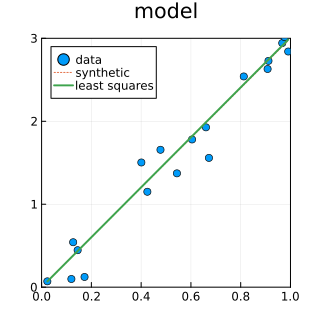

In [6]:
plot(X,Y_obs;
    seriestype=:scatter,
    label="data",title="model",
    framestyle=:box,aspect_ratio=1/3,
    size=(320,320),xlims=(0,1),ylims=(0,3))
plot!(X,[U(λ_synth,X) U(λ_lsq,X)];
    label=["synthetic" "least squares"],
    lw=[1 2],ls=[:dot :solid])
plot!(legend=:topleft)

Now let's implement the gradient descent algorithm. At first, let's compute all the derivatives analytically

In [7]:
function fit_gradient_descent(X,Y_obs; maxiter=50, λ_ini=10.0, γ=0.5)
    λ = λ_ini      # initial approximation for λ
    γ /= length(X) # correct for different objective
    λ_hist    = [λ,]
    conv_hist = [J(U(λ,X),Y_obs),]
    for _ in 1:maxiter
        ∂J_∂U = (U(λ,X).-Y_obs)'
        dU_dλ = X
        dJ_dλ = ∂J_∂U*dU_dλ
        λ -= γ*dJ_dλ
        push!(λ_hist,λ)
        push!(conv_hist,J(U(λ,X),Y_obs))
    end
    return λ,λ_hist,conv_hist
end

fit_gradient_descent (generic function with 1 method)

Fit the data using the developed function:

In [8]:
λ_gd,λ_hist,conv_hist = fit_gradient_descent(X,Y_obs)
@show λ_synth λ_lsq λ_gd

λ_synth = 3.0
λ_lsq = 3.0108067638706504
λ_gd = 3.010822116251692


3.010822116251692

The gradient descent converged reasonably well to the least squares solution.

We saved the convergence history. Let's animate the algorithm:

[ Info: Saved animation to C:\Users\krjac\AppData\Local\Temp\jl_qzUvuFiz8F.gif


Plots.AnimatedGif("C:\\Users\\krjac\\AppData\\Local\\Temp\\jl_qzUvuFiz8F.gif")
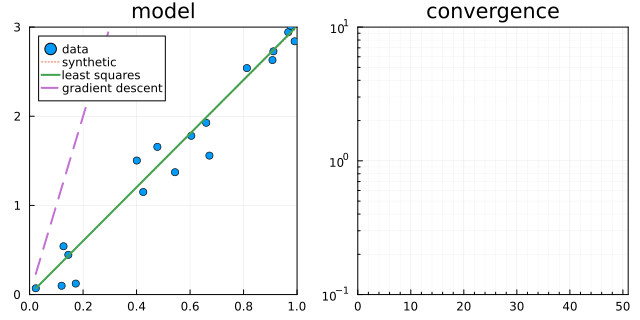

In [9]:
@gif for i in eachindex(λ_hist)
    p1 = plot(X,Y_obs;
        seriestype=:scatter,
        label="data",title="model",
        framestyle=:box,aspect_ratio=1/3,
        xlims=(0,1),ylims=(0,3))
    plot!(X,[U(λ_synth,X) U(λ_lsq,X) U(λ_hist[i],X)];
        label=["synthetic" "least squares" "gradient descent"],
        lw=[1 2 2],ls=[:dot :solid :dash])
    plot!(legend=:topleft)
    p2 = plot(1:i,conv_hist[1:i];
        label=false,title="convergence",
        framestyle=:box,yscale=:log10,minorgrid=true,
        xlims=(0,length(conv_hist)),ylims=(0.1,10.0))
    plot(p1,p2;layout=(1,2),size=(640,320))
end

We now have the working gradient descent algorithm. However, we still don't use the automatic differentiation! Let's fix this. First, we import the `Zygote.jl` package:

In [10]:
using Zygote

Try it out:

In [11]:
gradient(sin,π)

(-1.0,)

And modify the `fit_gradient_descent` funciton:

In [12]:
function fit_gradient_descent(X,Y_obs; maxiter=50, λ_ini=10.0, γ=0.5)
    λ = λ_ini      # initial approximation for λ
    γ /= length(X) # correct for different objective
    λ_hist    = [λ,]
    conv_hist = [J(U(λ,X),Y_obs),]
    for _ in 1:maxiter
        Y,back = pullback(U,λ,X)
        ∂J_∂U  = Y.-Y_obs
        dJ_dλ  = back(∂J_∂U)[1]
        λ -= γ*dJ_dλ
        push!(λ_hist,λ)
        push!(conv_hist,J(U(λ,X),Y_obs))
    end
    return λ,λ_hist,conv_hist
end

fit_gradient_descent (generic function with 1 method)

The `pullback` function takes the model function and its arguments, and returns the model value at that point and the pullback function, which computes the vector-Jacobian product (VJP) given the input vector.

Re-run the training and plotting to make sure everything works as expected.

🎉 Congrats, you've successfuly implemented a machine learning algorithm from scratch, using only the AD library!

## What's next?

By replacing the linear model with a 2D ice flow SIA solver, and using the adjoint trick, we can make inversions for SMB:

![2D SIA inversion](figures/inverse_2D_sia.gif)

This code runs completely on GPUs for both forward and adjoint problems.

Check the code [here](https://github.com/PTsolvers/PT-AD/blob/main/scripts_ok/adjoint_nonlin_diff_react_2D_cuda.jl)

## Combining models

💡 We can mix together several models to leverage the power of both physics-based and data-driven approaches:

$$
U(\boldsymbol{X},\boldsymbol{\lambda}_1,\boldsymbol{\lambda}_2) = (U_2 \circ U_1)(\boldsymbol{X},\boldsymbol{\lambda}_1,\boldsymbol{\lambda}_2).
$$

Physics-informed artificial neural networks (PIANNs) are example of such combination.

As long as both models are differentiable, we can compute gradients and run the training algorithm.

## Outlook

- Calculating gradients is an important building block for inverse modelling;
- Differential programming in Julia enables automatic generation of adjoints;
- We need to develop new tools to leverage new compiler technologies and unlock the full potential of latest hardware.


> "We believe that __future efforts should be taken towards physics-informed datascience glacier SMB and evolution modelling__. Adding physical constraints in ANNs ... would allow us to improve our understanding and confidence in predictions, to reduce our dependency on big datasets, and __to start bridging the gap between data science and physical methods.__"

<font size="4">Bolibar, J. et al. "Deep learning applied to glacier evolution modelling." _The Cryosphere_ (2020).</font>

### Thank you for your attention!

## Extras

Some packages for AD:

||||
|--:|:--|:--|
| <img src="figures/zygote_logo.png" style="height: 32px;"> | [Zygote.jl](https://fluxml.ai/Zygote.jl/)  | Julia  |
| <img src="figures/enzyme_logo.svg" style="height: 32px;"> | [Enzyme.jl](https://enzyme.mit.edu/julia/) | Julia  |
| <img src="figures/jax_logo.png" style="height: 32px;">    | [JAX](https://jax.readthedocs.io/) | Python |

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*